In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import xarray as xr

In [3]:
import scipy.signal
import torch
from torch import nn
from torch.utils.data import DataLoader

In [4]:
from Game import Game
from Player import Player
from Event import Event
from Moment import Moment
from Ball import Ball

In [5]:
position_ids = torch.arange(1024)[:, None]
d = 512
a = (position_ids/(10000*2*np.pi/2/np.pi)**(torch.arange(d)/d)).sin()

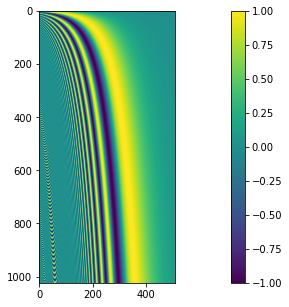

In [6]:
plt.figure(figsize=(20, 5))
plt.imshow(a.numpy()); plt.colorbar()

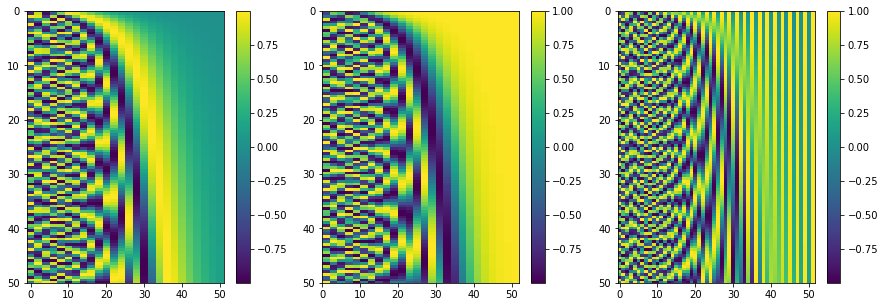

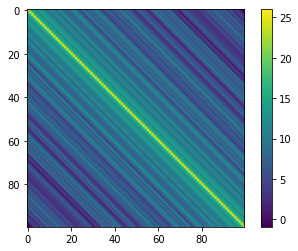

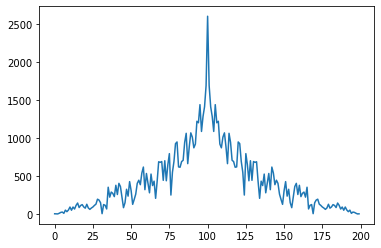

In [7]:
    
import util
a = util.fourier_pos(0, 50, t=torch.linspace(0, 50, 100), d=52, do_viz=True)
plt.imshow(a@a.T); plt.colorbar()
plt.show()
plt.plot([(a@a.T).diagonal(i).sum().item() for i in range(-100, 100)])
plt.show()

In [8]:
path = 'data/game2.json'
game = Game(path)
game.read_json(tqdm=tqdm)

loading  501


  0%|          | 0/501 [00:00<?, ?it/s]

In [9]:
game.team2onehot = {0: 0, game.home_team.id: 1, game.guest_team.id: 2}
print(len(game.team2onehot), game.team2onehot)
game.pid2onehot = {0: 0}
game.pid2onehot.update({a: idx+1 for idx, a in enumerate(game.player_ids_dict.keys())})
print(len(game.pid2onehot), game.pid2onehot)

3 {0: 0, 1610612745: 1, 1610612738: 2}
25 {0: 0, 2772: 1, 201951: 2, 203093: 3, 201977: 4, 2730: 5, 201935: 6, 203991: 7, 1891: 8, 203909: 9, 201147: 10, 1626149: 11, 202340: 12, 202738: 13, 203096: 14, 201973: 15, 202323: 16, 1626179: 17, 1626154: 18, 203935: 19, 203482: 20, 101135: 21, 203092: 22, 101161: 23, 203109: 24}


In [15]:
import preprocess
dg_raw = preprocess.load_data_game(game, tqdm=tqdm)
dg = preprocess.preprocess(dg_raw)
# list(zip([e.shape for e in dg_raw], [e[:, 2].sum() for e in dg_raw]))

  0%|          | 0/501 [00:00<?, ?it/s]

106032
66413
[-1 -1 -1 ... -1 -1 -1]
True


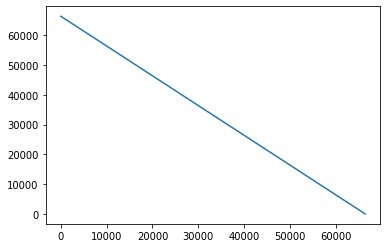

In [11]:
def preprocess(data_game):
    # concatenate all events' moments
    data_game = np.concatenate(data_game, axis=0).T
    t = data_game[0]
    
    # only include the first instance of a time stamp (to two decimals)
    t_binned = ((t+0.001)*100).astype(int)
    print(len(t_binned))
    _, idxs = np.unique(t_binned, return_index=True)
    print(len(idxs))
    data_game = data_game[:, idxs]
    
    # sort the times in case they're out of order
    idxs = np.argsort(data_game[0])[::-1]
    plt.plot(idxs)
    print((idxs[1:]-idxs[:-1]))
    print((idxs[1:]-idxs[:-1] == -1).all())
    data_game = data_game[:, idxs] #don't sort??
    return data_game.T
dg = preprocess(dg_raw)

In [12]:
a = []
for i in range(len(dg_raw)):
    t = dg_raw[i][:, 0]
    dt = np.diff(t)
    a.append(dt)
    # print(dt.min(), dt.max())


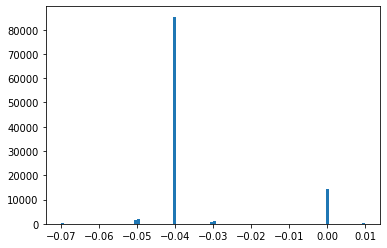

In [13]:
plt.hist(np.concatenate(a).clip(-.07, .01), bins=100);
# plt.yscale('log')

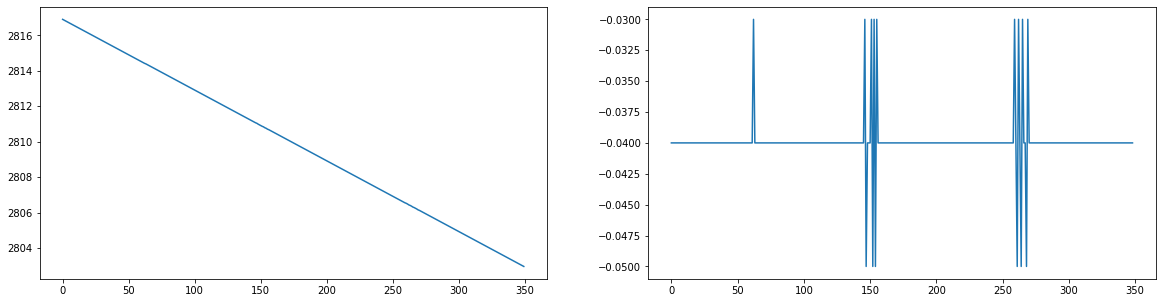

In [280]:
t = dg_raw[3][:, 0]
dt = np.diff(t)
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.plot(t)
plt.subplot(122)
# plt.hist(dt, bins=100);
plt.plot(dt)

In [277]:
dt.argmax()

72

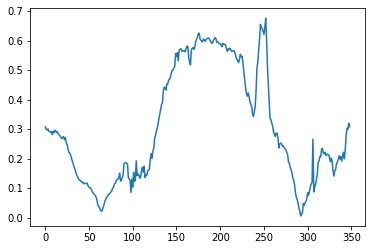

In [281]:
x = dg_raw[3][:, [10,11]]
v = x[1:]-x[:-1]
plt.plot(torch.from_numpy(v).norm(dim=-1).numpy())
# plt.gca().axvline(dt.argmax(),c='r')

In [13]:
np.isnan(dg).any(axis=0)

array([False, False,  True, False, False, False, False, False,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True])

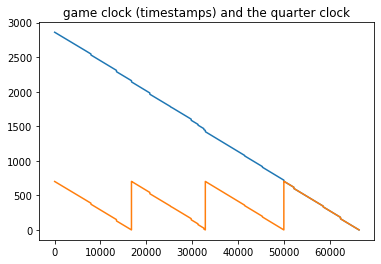

0.03 2861.14
-20.700000000000017 -0.043081220261398545 -0.009999999999763531


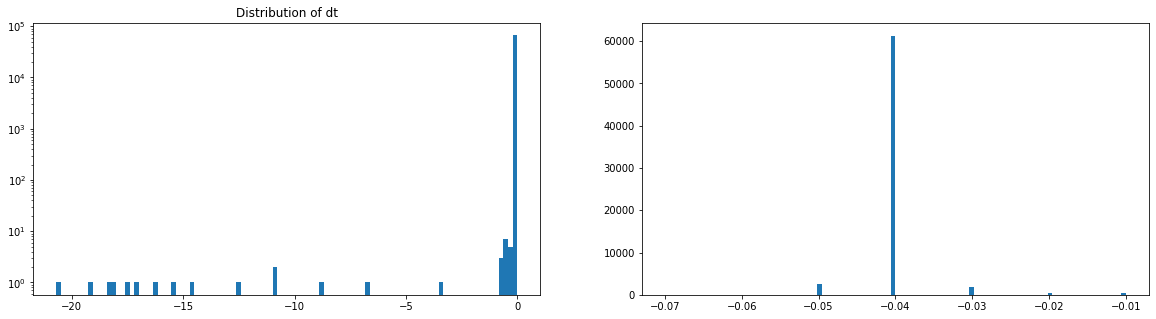

In [14]:
plt.plot(dg[:, 0])
plt.plot(dg[:, 1])
plt.title('game clock (timestamps) and the quarter clock')
plt.show()

t = dg[:, 0]
print(t.min(), t.max())
dt = np.diff(t)
assert (dt<0).all(), 'timestamps not all decreasing'
print(dt.min(), dt.mean(), dt.max())

plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.hist(dt, bins=100);
plt.title('Distribution of dt')
plt.yscale('log')
plt.subplot(122)
plt.hist(dt[dt>-.1], bins=100);
# plt.yscale('log')
plt.show()

(-0.05, 0.0)

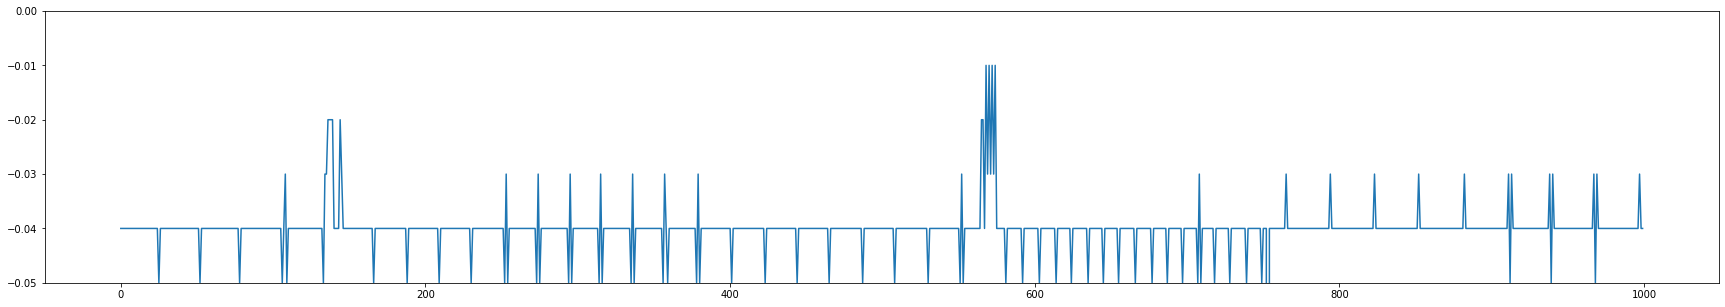

In [15]:
plt.figure(figsize=(30, 5))
plt.plot(dt[20000:21000])
plt.ylim(-.05, 0)

In [16]:
print(f"dt decreasing for {(dt<0.).sum()} frames and increasing for {(dt>=0.).sum()} frames")

dt decreasing for 66412 frames and increasing for 0 frames


(-3.4655285, 101.6141385, 6.304955500000001, 49.7933345)

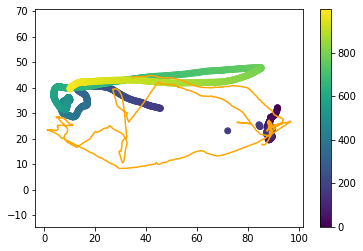

In [80]:
x = dg[:1000, 10]
y = dg[:1000, 11]
plt.scatter(x, y, c=np.arange(len(x)))
plt.colorbar()
x = dg[:1000, 5]
y = dg[:1000, 6]
plt.plot(x,y, color='orange')

plt.axis('equal')
# plt.ylim(0, 50)
# plt.xlim(0, 94)

In [16]:
import torch
from torch import nn

In [17]:
from collections import defaultdict

In [18]:
from constants import max_speed_ball, max_speed_human

In [19]:
from dataset import BasketballDataset

In [20]:
ds = BasketballDataset(game, dg, input_shot_clock=True, input_p_id=False, tqdm=tqdm)
# x_mean = ds.x.mean(axis=(0, 1))
# x_std = ds.x.std(axis=(0, 1))
# y_mean = ds.y.mean(axis=(0, 1))
# y_std = ds.y.std(axis=(0, 1))
# print([i.shape for i in ds[0]])
# print(len(ds))

Creating dataset
dg_m: torch.Size([66410, 4, 48]) | 

Removing 2150 frames for NaN values
Removing 9941 items for bad dt
Removing 70 frames for high ball speed
Removing 113 frames for high player speed
dg_m: torch.Size([54136, 4, 48]) | t_m: torch.Size([54136, 4]) | dt_m: torch.Size([54136, 3]) | dt: torch.Size([54136]) | t_shot: torch.Size([54136]) | id_p: torch.Size([54136, 11]) | id_team: torch.Size([54136, 11]) | x_m: torch.Size([54136, 4, 11, 3]) | v_m: torch.Size([54136, 3, 11, 3]) | a_m: torch.Size([54136, 2, 11, 3]) | x: torch.Size([54136, 11, 3]) | nx: torch.Size([54136, 11, 3]) | v: torch.Size([54136, 11, 3]) | nv: torch.Size([54136, 11, 3]) | a: torch.Size([54136, 11, 3]) | na: torch.Size([54136, 11, 3]) | 



In [21]:
ds.ds.keys()

dict_keys(['dg_m', 't_m', 'dt_m', 'dt', 't_shot', 'id_p', 'id_team', 'x_m', 'v_m', 'a_m', 'x', 'nx', 'v', 'nv', 'a', 'na'])

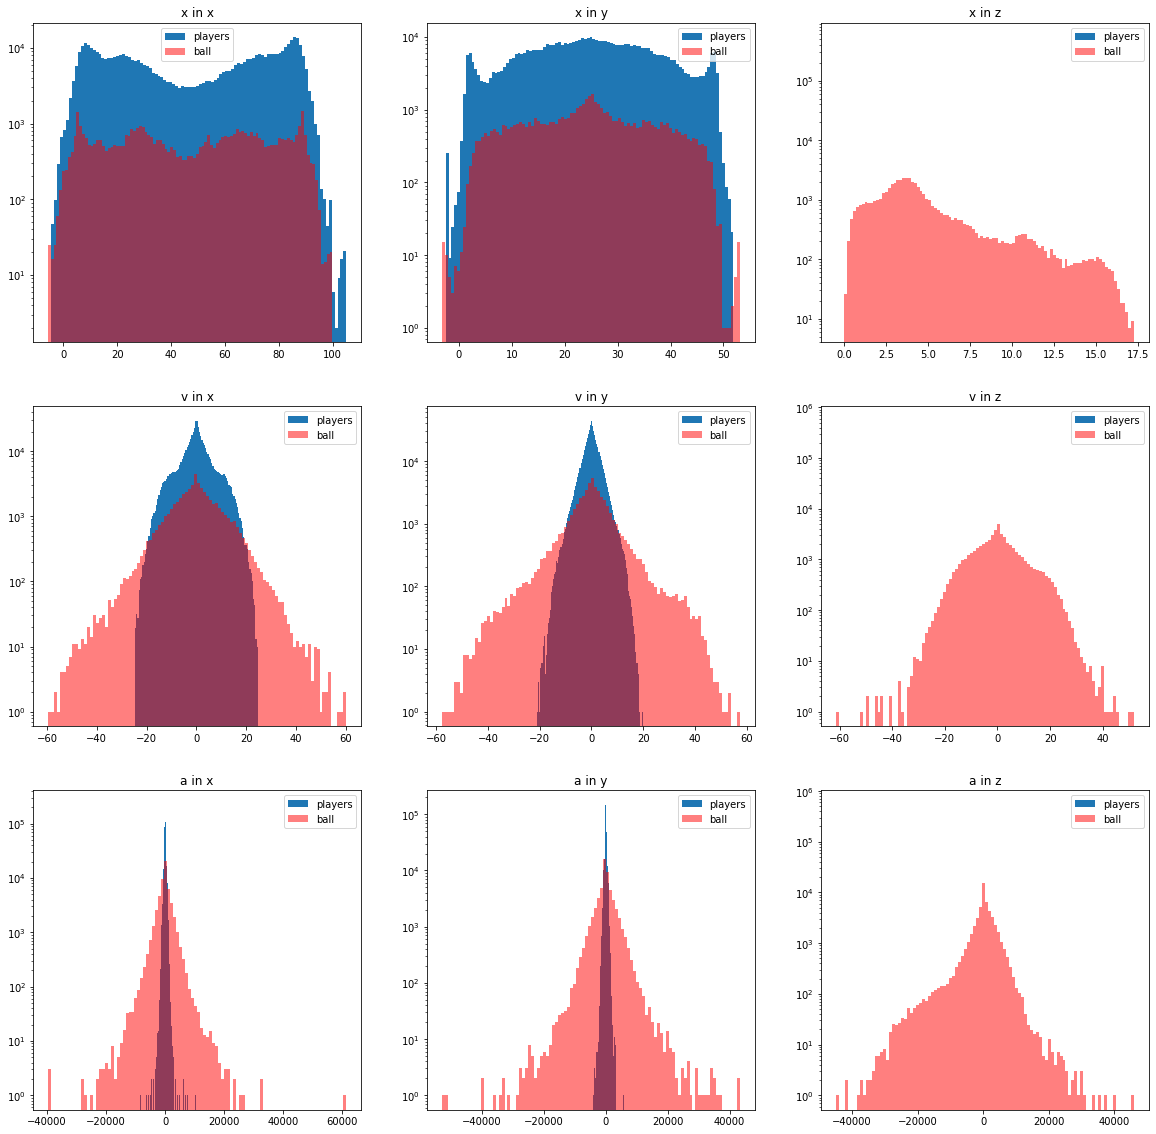

In [22]:
plt.figure(figsize=(20, 20))
for i, key in enumerate(['x', 'v', 'a']):
    for j, direction in enumerate(['x', 'y', 'z']):
        plt.subplot(3, 3, i*3+j+1)
        plt.title(f'{key} in {direction}')
        plt.hist(ds.ds[f'{key}'][..., 1:, j].flatten().numpy(), bins=100, label='players');
        plt.hist(ds.ds[f'{key}'][..., :1, j].flatten().numpy(), bins=100, color=[1,0,0,.5], label='ball');
        plt.yscale('log')
        plt.legend()
    
# plt.subplot(1, 4, 4)
# plt.hist(ds.ds['v'][..., 1:, :].norm(dim=-1).flatten().numpy(), bins=100);
# plt.hist(ds.ds['v'][..., :1, :].norm(dim=-1).flatten().numpy(), bins=100, color=[1,0,0,.5]);
# plt.yscale('log')
plt.show()

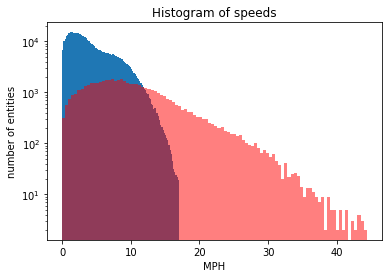

In [23]:
speed = (ds.ds['v'].norm(dim=-1))
plt.title('Histogram of speeds')
plt.xlabel('MPH'); plt.ylabel('number of entities')
plt.hist(speed[:, 1:].flatten().numpy()/1.467, bins=100, label='Players');
plt.hist(speed[:, 0].flatten().numpy()/1.467, bins=100, color=[1,0,0,.5], label='Ball');
plt.yscale('log')

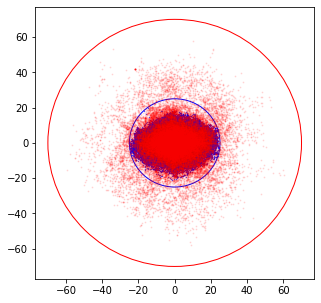

In [24]:
v = ds.ds['v']

plt.figure(figsize=(5,5))
plt.scatter(v[:, 1:, 0].flatten().numpy(), v[:, 1:, 1].flatten().numpy(), s=.1, color=[0., 0., 1., 1.])
plt.gca().add_patch(plt.Circle((0, 0), max_speed_human, color='b', fill=False))

plt.scatter(v[:, 0, 0].flatten().numpy(), v[:, 0, 1].flatten().numpy(), s=1, color=[1., 0, 0, .1])
plt.gca().add_patch(plt.Circle((0, 0), max_speed_ball, color='r', fill=False))

plt.show()


In [64]:
from discrete_prob import DiscretizeContinuousSpace
n_bins = np.ones(2, dtype=int)*2
dcs = DiscretizeContinuousSpace(np.zeros(2)-1.5, np.zeros(2)+1.5, n_bins)


[-1.5 -1.5] [1.5 1.5] [2 2]


In [494]:
v = ds.ds['nv']

In [495]:
# v.min(dim=-2).values.min(dim=-2).values, v.max(dim=-2).values.max(dim=-2).values
v.mean(dim=(-2, -3)), v.std(dim=(-2, -3))*3, 

(tensor([-0.0462, -0.0166, -0.0024], dtype=torch.float64),
 tensor([22.3087, 13.4190,  8.4228], dtype=torch.float64))

In [496]:
dcs.vec2bin(v[..., :2].numpy())

array([[1, 3, 3, ..., 1, 1, 2],
       [1, 3, 3, ..., 1, 3, 2],
       [0, 3, 3, ..., 1, 3, 2],
       ...,
       [3, 1, 2, ..., 3, 3, 0],
       [1, 1, 2, ..., 3, 3, 0],
       [2, 1, 2, ..., 3, 3, 0]])

  0%|          | 0/1000 [00:00<?, ?it/s]

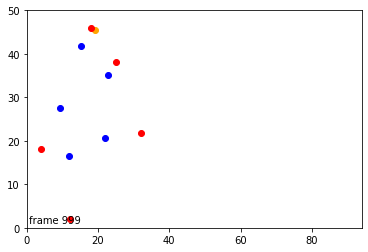

In [667]:
from celluloid import Camera
from IPython.display import HTML

fig = plt.figure()
camera = Camera(fig)
for frame_idx in tqdm(range(1000)):
    plt.text(0.5, 1.01, f'frame {frame_idx}')#, transform=ax.transAxes)
    plt.scatter(*ds.ds['x'][frame_idx, :1][:, :2].numpy().T, c='orange')
    plt.scatter(*ds.ds['x'][frame_idx, 1:6][:, :2].numpy().T, c='b')
    plt.scatter(*ds.ds['x'][frame_idx, 6:][:, :2].numpy().T, c='r')
    plt.xlim(0, 94)
    plt.ylim(0, 50)
    camera.snap()

animation = camera.animate(interval=40)
# plt.close(fig)
# HTML(animation.to_html5_video())
animation.save('animation.mp4')

# things to track for this experiment:
- ball x, ball y
- p1 x, p1 y, p1 vx, p1 vy, p1 ax, p1 ay
- ...


# outputs
- movements


In [65]:
from net import ModelNet

In [66]:
    
net = ModelNet(game)
# net(x_batch).shape

In [67]:
from discrete_prob import DiscretizeContinuousSpace
n_bins = np.ones(2, dtype=int)*2
dcs = DiscretizeContinuousSpace(np.zeros(2)-1.5, np.zeros(2)+1.5, n_bins)

[-1.5 -1.5] [1.5 1.5] [2 2]


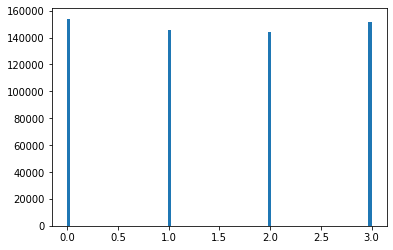

In [68]:
a = ds.ds['x']
x_mean, x_std = a.mean(dim=(-2, -3)), a.std(dim=(-2, -3))
batch_y = torch.from_numpy(dcs.vec2bin(ds.ds['nv'][..., :2].numpy()))
plt.hist(batch_y.flatten().numpy(), bins=100);

In [69]:
ds.ds['x'].shape

torch.Size([54136, 11, 3])

In [70]:
ds.ds['x'].numel()*4*10/1e9

0.07145952

In [71]:
from dataset import index_data_dict

In [74]:
net = ModelNet(game, n_inputs=60, n_outputs=3, embed_dim=60, n_heads=5, mlp_dim=120)
loss_fn = nn.CrossEntropyLoss()

print(np.sum([p.numel() for p in net.parameters()]))
for p in net.parameters():
    p.data[...] = 1e-3*torch.randn_like(p)

opt = torch.optim.Adam(net.parameters(), lr=1e-2)

losses = []
for idx_epoch in tqdm(range(20)):
    pbar = tqdm(torch.randperm(len(ds.ds['x'])).split(512), leave=False)
    for batch_idx in pbar:
        batch = index_data_dict(ds.ds, batch_idx)
        x = batch['x'].float()
        # x_normalized = ((x-x_mean)/x_std).float()
        id_team = batch['id_team']
        id_player = batch['id_p']
        
        # inputs = torch.cat([x_normalized, nn.functional.one_hot(batch['id_team'].long()).float()], dim=-1)
        
        # y = torch.from_numpy(dcs.vec2bin(batch['nv'][..., :2].numpy()))
        y = batch['nv']
        
        y_batch_pred = net.forward(x, id_team=id_team, id_player=id_player)
        
        # print(batch_y.shape, y_batch_pred.shape)
        # loss = loss_fn(y_batch_pred.reshape(-1, 4), y.flatten())
        loss = (y_batch_pred-y).pow(2.).mean()
        
        opt.zero_grad()
        loss.backward()
        opt.step()

        losses.append(loss.item())
        pbar.set_postfix({'loss': loss.item()})


152823


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

KeyboardInterrupt: 

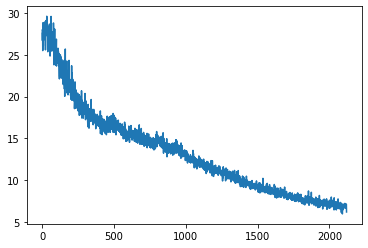

In [79]:
plt.plot(losses) #for the mse loss with fourier x, embedded id_team, embedded id_player

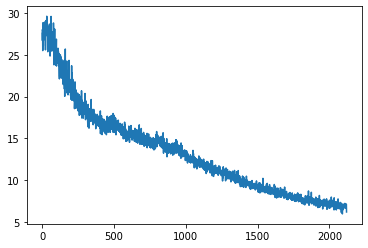

In [79]:
plt.plot(losses) #for the mse loss with fourier x, embedded id_team, embedded id_player

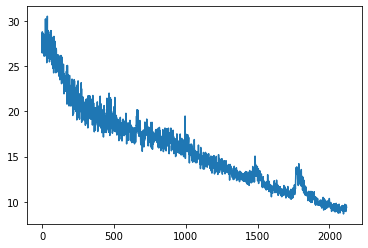

In [53]:
plt.plot(losses) #for the mse loss with fourier x, embedded id_team

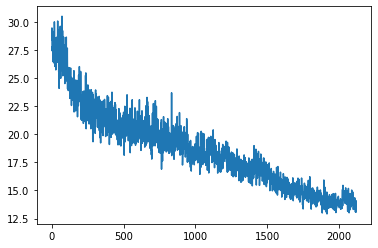

In [616]:
plt.plot(losses) #for the mse loss with xyz inputs

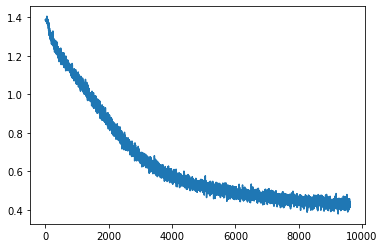

In [612]:
plt.plot(losses) #for the crossentropy 4-quadrant classification loss with xyz inputs

In [535]:
v = ds.ds['v']
nv = ds.ds['nv']
a = dcs.vec2bin(v[..., :2].numpy())
b = dcs.vec2bin(nv[..., :2].numpy())

In [118]:
batch = index_data_dict(ds.ds, 0)
x = batch['x'][None].float()
id_team = batch['id_team'][None]
id_player = batch['id_p'][None]
xs = []

for i in tqdm(range(100)):
    xs.append(x.detach().cpu().clone())
    nv = net.forward(x, id_team, id_player)
    x = x+nv*0.04

xs = torch.stack(xs)[:, 0]

  0%|          | 0/100 [00:00<?, ?it/s]

In [121]:
x.shape

torch.Size([11, 3])

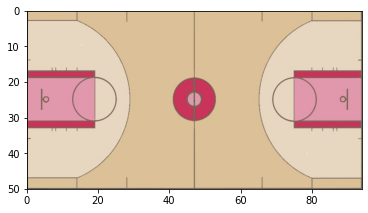

In [181]:
from Constant import Constant

court = plt.imread("court.png")
plt.imshow(court, zorder=0, extent=[Constant.X_MIN, Constant.X_MAX - Constant.DIFF,
                                    Constant.Y_MAX, Constant.Y_MIN])

In [182]:
from celluloid import Camera
from IPython.display import HTML

fig = plt.figure()
camera = Camera(fig)
for i in tqdm(range(0, 100, 1)):
    x = xs[i]
    plt.text(0.5, 1.01, f'frame {i}')#, transform=ax.transAxes)
    plt.scatter(*x[:1, :2].numpy().T, c='orange')
    plt.scatter(*x[1:6, :2].numpy().T, c='b')
    plt.scatter(*x[6:, :2].numpy().T, c='r')
    plt.xlim(0, 94)
    plt.ylim(0, 50)
    
    plt.imshow(court, zorder=0, extent=[Constant.X_MIN, Constant.X_MAX - Constant.DIFF,
                                        Constant.Y_MAX, Constant.Y_MIN])
    camera.snap()

animation = camera.animate(interval=40)
plt.close(fig)
HTML(animation.to_html5_video())
# animation.save('animation.mp4')

  0%|          | 0/100 [00:00<?, ?it/s]

In [169]:
success = []
for experiment in tqdm(range(1000)):
    np.random.seed(experiment)
    box_slips = np.random.permutation(100)
    found = np.zeros((100,), dtype=bool)
    for i in range(100):
        current_box = i
        for t in range(50):
            if box_slips[current_box]==i:
                found[i] = True
                break
            current_box = box_slips[current_box]

    # print(f'success: {found.all()}, # of people found their number: {found.sum()}, # of people not found their number {100-found.sum()}')
    success.append(found.all())

print(np.array(success).sum()/len(success))


  0%|          | 0/1000 [00:00<?, ?it/s]

0.31
